<a href="https://colab.research.google.com/github/yjawahar/art/blob/main/pix2pixhdfinal1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Loaded checkpoint: checkpoint_phase1_epoch2.pth
Loaded checkpoint: checkpoint_phase1_epoch2.pth
Loaded checkpoint: checkpoint_phase2_epoch2.pth
Loaded checkpoint: checkpoint_phase2_epoch2.pth
Loaded checkpoint: checkpoint_phase2_epoch2.pth

Example 1:
Label map shape: torch.Size([1, 35, 1024, 2048])
Class distribution:
Class 1: 81534 pixels
Class 3: 31634 pixels
Class 4: 16196 pixels
Class 5: 1191 pixels
Class 7: 811306 pixels
Class 8: 202057 pixels
Class 11: 712984 pixels
Class 12: 29502 pixels
Class 13: 3009 pixels
Class 17: 14774 pixels
Class 19: 13946 pixels
Class 20: 7700 pixels
Class 21: 13305 pixels
Class 22: 852 pixels
Class 23: 62310 pixels
Class 24: 3175 pixels
Class 26: 91260 pixels
Class 27: 417 pixels
Label indices range: 1 to 27

Example 2:
Label map shape: torch.Size([1, 35, 1024, 2048])
Class distribution:
Class 1: 81534 pixels
Class 3: 31634 pixels
Class 4: 47382 pixels
Class 7: 818645 pixels
Class 8: 31214 pixels
Class 11: 213687 pixels
Class

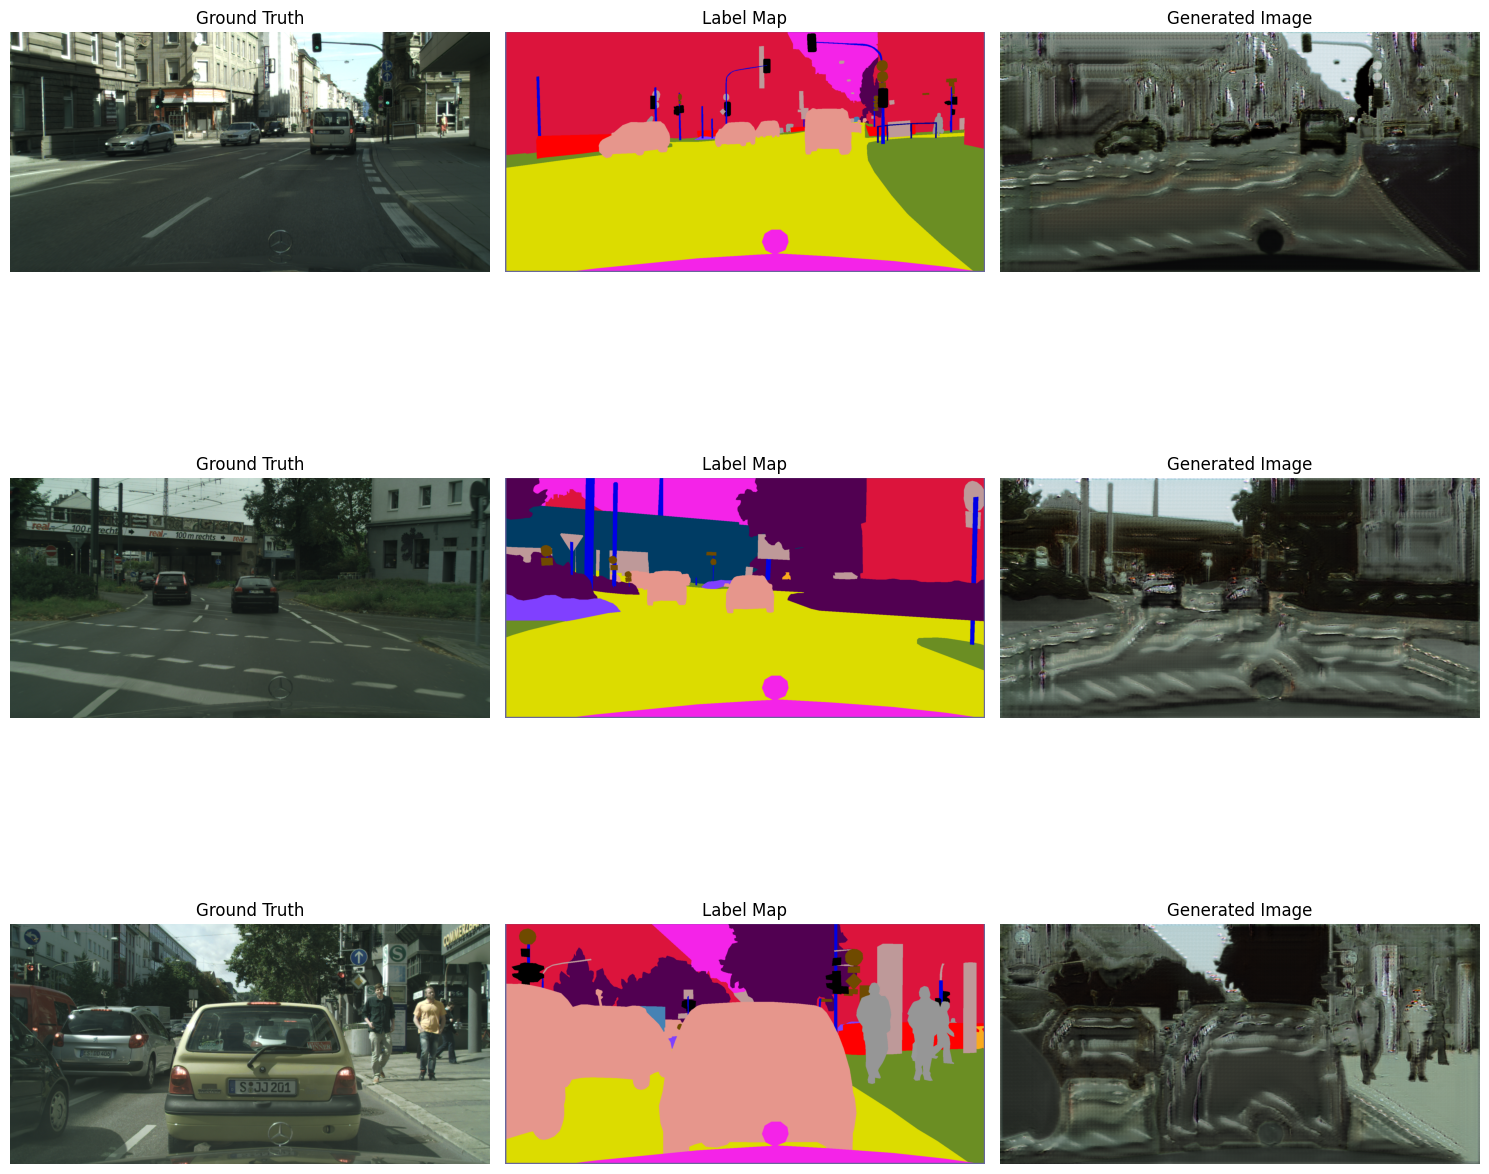

In [19]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
import json
import colorsys

# ==============================================
# MODEL DEFINITIONS
# ==============================================

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3, padding=0),
            nn.InstanceNorm2d(channels, affine=False),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3, padding=0),
            nn.InstanceNorm2d(channels, affine=False),
        )

    def forward(self, x):
        return x + self.layers(x)

class GlobalGenerator(nn.Module):
    def __init__(self, in_channels, out_channels, base_channels=64, fb_blocks=3, res_blocks=9):
        super().__init__()
        g1 = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, base_channels, kernel_size=7, padding=0),
            nn.InstanceNorm2d(base_channels, affine=False),
            nn.ReLU(inplace=True),
        ]

        channels = base_channels
        for _ in range(fb_blocks):
            g1 += [
                nn.Conv2d(channels, 2*channels, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(2*channels, affine=False),
                nn.ReLU(inplace=True),
            ]
            channels *= 2

        for _ in range(res_blocks):
            g1 += [ResidualBlock(channels)]

        for _ in range(fb_blocks):
            g1 += [
                nn.ConvTranspose2d(channels, channels//2, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(channels//2, affine=False),
                nn.ReLU(inplace=True),
            ]
            channels //= 2

        self.out_layers = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(base_channels, out_channels, kernel_size=7, padding=0),
            nn.Tanh(),
        )
        self.g1 = nn.Sequential(*g1)

    def forward(self, x):
        x = self.g1(x)
        return self.out_layers(x)

class LocalEnhancer(nn.Module):
    def __init__(self, in_channels, out_channels, base_channels=32,
                 global_fb_blocks=3, global_res_blocks=9, local_res_blocks=3):
        super().__init__()
        global_base_channels = 2 * base_channels
        self.downsample = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)
        self.g1 = GlobalGenerator(in_channels, out_channels, base_channels=global_base_channels,
                                fb_blocks=global_fb_blocks, res_blocks=global_res_blocks).g1

        self.g2 = nn.ModuleList([
            nn.Sequential(
                nn.ReflectionPad2d(3),
                nn.Conv2d(in_channels, base_channels, kernel_size=7, padding=0),
                nn.InstanceNorm2d(base_channels, affine=False),
                nn.ReLU(inplace=True),
                nn.Conv2d(base_channels, 2*base_channels, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(2*base_channels, affine=False),
                nn.ReLU(inplace=True),
            ),
            nn.Sequential(
                *[ResidualBlock(2*base_channels) for _ in range(local_res_blocks)],
                nn.ConvTranspose2d(2*base_channels, base_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(base_channels, affine=False),
                nn.ReLU(inplace=True),
                nn.ReflectionPad2d(3),
                nn.Conv2d(base_channels, out_channels, kernel_size=7, padding=0),
                nn.Tanh(),
            )
        ])

    def forward(self, x):
        x_g1 = self.downsample(x)
        x_g1 = self.g1(x_g1)
        x_g2 = self.g2[0](x)
        return self.g2[1](x_g1 + x_g2)

class Discriminator(nn.Module):
    def __init__(self, in_channels, base_channels=64, n_layers=3):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=4, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
        ))

        channels = base_channels
        for _ in range(1, n_layers):
            prev_channels = channels
            channels = min(2*channels, 512)
            self.layers.append(nn.Sequential(
                nn.Conv2d(prev_channels, channels, kernel_size=4, stride=2, padding=2),
                nn.InstanceNorm2d(channels, affine=False),
                nn.LeakyReLU(0.2, inplace=True),
            ))

        prev_channels = channels
        channels = min(2*channels, 512)
        self.layers.append(nn.Sequential(
            nn.Conv2d(prev_channels, channels, kernel_size=4, stride=1, padding=2),
            nn.InstanceNorm2d(channels, affine=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels, 1, kernel_size=4, stride=1, padding=2),
        ))

    def forward(self, x):
        outputs = []
        for layer in self.layers:
            x = layer(x)
            outputs.append(x)
        return outputs

class MultiscaleDiscriminator(nn.Module):
    def __init__(self, in_channels, base_channels=64, n_layers=3, n_discriminators=3):
        super().__init__()
        self.discriminators = nn.ModuleList()
        for _ in range(n_discriminators):
            self.discriminators.append(Discriminator(in_channels, base_channels, n_layers))
        self.downsample = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)

    def forward(self, x):
        outputs = []
        for i, discriminator in enumerate(self.discriminators):
            if i != 0:
                x = self.downsample(x)
            outputs.append(discriminator(x))
        return outputs

    @property
    def n_discriminators(self):
        return len(self.discriminators)

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, base_channels=16, n_layers=4):
        super().__init__()
        self.out_channels = out_channels
        channels = base_channels

        layers = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, base_channels, kernel_size=7, padding=0),
            nn.InstanceNorm2d(base_channels),
            nn.ReLU(inplace=True),
        ]

        for _ in range(n_layers):
            layers += [
                nn.Conv2d(channels, 2*channels, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(2*channels),
                nn.ReLU(inplace=True),
            ]
            channels *= 2

        for _ in range(n_layers):
            layers += [
                nn.ConvTranspose2d(channels, channels//2, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(channels//2),
                nn.ReLU(inplace=True),
            ]
            channels //= 2

        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(base_channels, out_channels, kernel_size=7, padding=0),
            nn.Tanh(),
        ]
        self.layers = nn.Sequential(*layers)

    def instancewise_average_pooling(self, x, inst):
        x_mean = torch.zeros_like(x)
        inst = inst.to(torch.int32)

        unique_instances = torch.unique(inst)
        for i in unique_instances:
            if i == 0:
                continue
            mask = (inst == i)
            for c in range(self.out_channels):
                x_mean[:, c][mask[:, 0]] = x[:, c][mask[:, 0]].mean()
        return x_mean

    def forward(self, x, inst):
        x = self.layers(x)
        return self.instancewise_average_pooling(x, inst)

class VGG19(nn.Module):
    def __init__(self):
        super().__init__()
        vgg_features = models.vgg19(pretrained=True).features

        self.f1 = nn.Sequential(*[vgg_features[x] for x in range(2)])
        self.f2 = nn.Sequential(*[vgg_features[x] for x in range(2,7)])
        self.f3 = nn.Sequential(*[vgg_features[x] for x in range(7,12)])
        self.f4 = nn.Sequential(*[vgg_features[x] for x in range(12,21)])
        self.f5 = nn.Sequential(*[vgg_features[x] for x in range(21,30)])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h1 = self.f1(x)
        h2 = self.f2(h1)
        h3 = self.f3(h2)
        h4 = self.f4(h3)
        h5 = self.f5(h4)
        return [h1, h2, h3, h4, h5]

class Loss(nn.Module):
    def __init__(self, lambda1=10., lambda2=10., device='cuda', norm_weight_to_one=True):
        super().__init__()
        self.vgg = VGG19().to(device)
        self.vgg_weights = [1.0/32, 1.0/16, 1.0/8, 1.0/4, 1.0]

        scale = max(1.0, lambda1, lambda2) if norm_weight_to_one else 1.0
        self.lambda0 = 1.0 / scale
        self.lambda1 = lambda1 / scale
        self.lambda2 = lambda2 / scale

    def adv_loss(self, discriminator_preds, is_real):
        target = torch.ones_like if is_real else torch.zeros_like
        adv_loss = 0.0
        for preds in discriminator_preds:
            pred = preds[-1]
            adv_loss += F.mse_loss(pred, target(pred))
        return adv_loss

    def fm_loss(self, real_preds, fake_preds):
        fm_loss = 0.0
        for real_features, fake_features in zip(real_preds, fake_preds):
            for real_feature, fake_feature in zip(real_features, fake_features):
                fm_loss += F.l1_loss(real_feature.detach(), fake_feature)
        return fm_loss

    def vgg_loss(self, x_real, x_fake):
        vgg_real = self.vgg(x_real)
        vgg_fake = self.vgg(x_fake)
        vgg_loss = 0.0
        for real, fake, weight in zip(vgg_real, vgg_fake, self.vgg_weights):
            vgg_loss += weight * F.l1_loss(real.detach(), fake)
        return vgg_loss

    def forward(self, x_real, label_map, instance_map, boundary_map, encoder, generator, discriminator):
        feature_map = encoder(x_real, instance_map)
        x_fake = generator(torch.cat((label_map, boundary_map, feature_map), dim=1))

        fake_preds_for_g = discriminator(torch.cat((label_map, boundary_map, x_fake), dim=1))
        fake_preds_for_d = discriminator(torch.cat((label_map, boundary_map, x_fake.detach()), dim=1))
        real_preds_for_d = discriminator(torch.cat((label_map, boundary_map, x_real.detach()), dim=1))

        g_loss = (
            self.lambda0 * self.adv_loss(fake_preds_for_g, True) +
            self.lambda1 * self.fm_loss(real_preds_for_d, fake_preds_for_g) / discriminator.n_discriminators +
            self.lambda2 * self.vgg_loss(x_fake, x_real)
        )
        d_loss = 0.5 * (
            self.adv_loss(real_preds_for_d, True) +
            self.adv_loss(fake_preds_for_d, False)
        )
        return g_loss, d_loss, x_fake.detach()

def scale_width(img, target_width, method):
    w, h = img.size
    if w == target_width: return img
    target_height = target_width * h // w
    return img.resize((target_width, target_height), method)

class CityscapesDataset(torch.utils.data.Dataset):
    def __init__(self, paths, target_width=1024, n_classes=35):
        super().__init__()
        self.n_classes = n_classes
        self.examples = {}

        if isinstance(paths, str):
            self.load_examples_from_dir(paths)
        elif isinstance(paths, list):
            for path in paths:
                self.load_examples_from_dir(path)
        else:
            raise ValueError('paths should be string or list')

        self.examples = list(self.examples.values())
        assert all(len(example) == 3 for example in self.examples)

        self.img_transforms = transforms.Compose([
            transforms.Lambda(lambda img: scale_width(img, target_width, Image.BICUBIC)),
            transforms.Lambda(lambda img: np.array(img)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        self.map_transforms = transforms.Compose([
            transforms.Lambda(lambda img: scale_width(img, target_width, Image.NEAREST)),
            transforms.Lambda(lambda img: np.array(img)),
            transforms.ToTensor(),
        ])

    def load_examples_from_dir(self, abs_path):
        img_suffix = '_leftImg8bit.png'
        label_suffix = '_gtFine_labelIds.png'
        inst_suffix = '_gtFine_instanceIds.png'

        for root, _, files in os.walk(abs_path):
            for f in files:
                if f.endswith(img_suffix):
                    prefix = f[:-len(img_suffix)]
                    attr = 'orig_img'
                elif f.endswith(label_suffix):
                    prefix = f[:-len(label_suffix)]
                    attr = 'label_map'
                elif f.endswith(inst_suffix):
                    prefix = f[:-len(inst_suffix)]
                    attr = 'inst_map'
                else:
                    continue

                if prefix not in self.examples:
                    self.examples[prefix] = {}
                self.examples[prefix][attr] = os.path.join(root, f)

    def __getitem__(self, idx):
        example = self.examples[idx]
        img = Image.open(example['orig_img']).convert('RGB')
        inst = Image.open(example['inst_map'])
        label = Image.open(example['label_map'])

        img = self.img_transforms(img)
        inst = self.map_transforms(inst)

        # Convert label to numpy array first
        label_np = np.array(label)

        # Create one-hot encoded tensor
        label_tensor = torch.zeros(self.n_classes, *label_np.shape)
        for class_id in range(self.n_classes):
            label_tensor[class_id] = torch.from_numpy((label_np == class_id).astype(np.float32))

        inst = inst.to(torch.int32)
        bound = torch.zeros_like(inst, dtype=torch.float32)

        bound[:, :, 1:] = bound[:, :, 1:] + (inst[:, :, 1:] != inst[:, :, :-1]).float()
        bound[:, :, :-1] = bound[:, :, :-1] + (inst[:, :, 1:] != inst[:, :, :-1]).float()
        bound[:, 1:, :] = bound[:, 1:, :] + (inst[:, 1:, :] != inst[:, :-1, :]).float()
        bound[:, :-1, :] = bound[:, :-1, :] + (inst[:, 1:, :] != inst[:, :-1, :]).float()

        bound = torch.clamp(bound, 0, 1)

        return (img, label_tensor, inst.to(torch.float32), bound)

    def __len__(self):
        return len(self.examples)

    @staticmethod
    def collate_fn(batch):
        imgs, labels, insts, bounds = [], [], [], []
        for (x, l, i, b) in batch:
            imgs.append(x)
            labels.append(l)
            insts.append(i)
            bounds.append(b)
        return (
            torch.stack(imgs, dim=0),
            torch.stack(labels, dim=0),
            torch.stack(insts, dim=0),
            torch.stack(bounds, dim=0),
        )

# ==============================================
# CHECKPOINT MANAGEMENT
# ==============================================

CHECKPOINT_DIR = '/content/drive/MyDrive/gaugan_checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def save_checkpoint(phase, models, optimizers, schedulers, epoch, centroids=None):
    checkpoint = {
        'phase': phase,
        'epoch': epoch,
        'encoder_state': models[0].state_dict(),
        'generator_state': models[1].state_dict(),
        'discriminator_state': models[2].state_dict(),
        'g_optimizer': optimizers[0].state_dict(),
        'd_optimizer': optimizers[1].state_dict(),
        'g_scheduler': schedulers[0].state_dict(),
        'd_scheduler': schedulers[1].state_dict(),
    }

    filename = f'checkpoint_phase{phase}_epoch{epoch}.pth'
    torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, filename))

    if centroids is not None:
        centroids_serializable = {k: [arr.tolist() for arr in v] for k, v in centroids.items()}
        with open(os.path.join(CHECKPOINT_DIR, f'centroids_phase{phase}_epoch{epoch}.json'), 'w') as f:
            json.dump(centroids_serializable, f)

    print(f"Saved checkpoint: {filename}")

def load_checkpoint(phase):
    checkpoints = [f for f in os.listdir(CHECKPOINT_DIR) if f.startswith(f'checkpoint_phase{phase}')]
    if not checkpoints:
        return None, 0, None

    checkpoints.sort(key=lambda x: int(x.split('_epoch')[1].split('.')[0]))
    latest_checkpoint = checkpoints[-1]
    checkpoint_path = os.path.join(CHECKPOINT_DIR, latest_checkpoint)
    epoch = int(latest_checkpoint.split('_epoch')[1].split('.')[0])

    checkpoint = torch.load(checkpoint_path)

    centroids_file = f'centroids_phase{phase}_epoch{epoch}.json'
    centroids = None
    if os.path.exists(os.path.join(CHECKPOINT_DIR, centroids_file)):
        with open(os.path.join(CHECKPOINT_DIR, centroids_file), 'r') as f:
            centroids_loaded = json.load(f)
            centroids = {int(k): [np.array(v) for v in vl] for k, vl in centroids_loaded.items()}

    print(f"Loaded checkpoint: {latest_checkpoint}")
    return checkpoint, epoch, centroids

# ==============================================
# VISUALIZATION FUNCTIONS
# ==============================================

def visualize_comparison(dataloader, num_examples=3, device='cuda'):
    """Visualize comparison between ground truth, input label map, and generated image"""
    checkpoint, _, centroids = load_checkpoint(2)
    if not checkpoint:
        raise ValueError("No checkpoint found for phase 2")

    encoder = Encoder(3, 3).to(device)
    generator = LocalEnhancer(n_classes + 3 + 1, 3).to(device)

    encoder.load_state_dict(checkpoint['encoder_state'])
    generator.load_state_dict(checkpoint['generator_state'])

    encoder.eval()
    generator.eval()

    examples = []
    for x, labels, insts, bounds in dataloader:
        if len(examples) >= num_examples:
            break
        examples.append((x, labels, insts, bounds))

    # Official Cityscapes color palette (for 35 classes)
    cityscapes_palette = [
        [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156], [190, 153, 153],
        [153, 153, 153], [250, 170, 30], [220, 220, 0], [107, 142, 35], [152, 251, 152],
        [70, 130, 180], [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70],
        [0, 60, 100], [0, 80, 100], [0, 0, 230], [119, 11, 32], [0, 0, 0],
        # Additional colors for remaining classes
        [111, 74, 0], [81, 0, 81], [128, 64, 255], [244, 35, 232], [150, 150, 150],
        [250, 170, 160], [230, 150, 140], [70, 130, 180], [180, 165, 180], [107, 142, 35],
        [70, 70, 70], [153, 153, 153], [190, 153, 153], [250, 170, 30], [220, 220, 0]
    ]

    def create_palette(n_classes):
        palette = np.zeros((n_classes, 3), dtype=np.uint8)
        for i in range(min(n_classes, len(cityscapes_palette))):
            palette[i] = cityscapes_palette[i]

        # Generate remaining colors if needed
        for i in range(len(cityscapes_palette), n_classes):
            hue = (i * 0.618) % 1.0
            sat = 0.7 + 0.2 * ((i % 3) / 3)
            val = 0.8 + 0.15 * ((i % 2) / 2)
            r, g, b = colorsys.hsv_to_rgb(hue, sat, val)
            palette[i] = [
                max(0, min(255, int(255 * r))),
                max(0, min(255, int(255 * g))),
                max(0, min(255, int(255 * b)))
            ]
        return palette

    palette = create_palette(n_classes)

    with torch.no_grad():
        fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5*num_examples))
        if num_examples == 1:
            axes = axes.reshape(1, -1)

        for i, (x_real, label_map, inst_map, bound_map) in enumerate(examples):
            print(f"\nExample {i+1}:")
            print(f"Label map shape: {label_map.shape}")
            class_indices = torch.argmax(label_map, dim=1)
            unique_classes, counts = torch.unique(class_indices, return_counts=True)
            print("Class distribution:")
            for cls, cnt in zip(unique_classes, counts):
                print(f"Class {cls.item()}: {cnt.item()} pixels")

            x_real = x_real.to(device)
            label_map = label_map.to(device)
            inst_map = inst_map.to(device)
            bound_map = bound_map.to(device)

            # Generate feature map
            b, _, h, w = label_map.shape
            feature_map = torch.zeros((b, 3, h, w), device=device).to(label_map.dtype)

            if centroids is not None:
                inst_map_int = inst_map.to(torch.int32)
                for inst_id in torch.unique(inst_map_int):
                    if inst_id == 0:
                        continue
                    label = int(inst_id.item() if inst_id.item() < 1000 else inst_id.item() // 1000)
                    if label < n_classes and label in centroids and len(centroids[label]) > 0:
                        centroid_idx = random.randint(0, len(centroids[label])-1)
                        idx = torch.nonzero(inst_map_int == inst_id, as_tuple=False)
                        feature_map[idx[:,0], :, idx[:,2], idx[:,3]] = torch.tensor(
                            centroids[label][centroid_idx], device=device)
            else:
                feature_map = encoder(x_real, inst_map)

            x_fake = generator(torch.cat((label_map, bound_map, feature_map), dim=1))

            # Convert to numpy for visualization
            real_img = (x_real[0].cpu().numpy().transpose(1, 2, 0) + 1) / 2
            fake_img = (x_fake[0].cpu().numpy().transpose(1, 2, 0) + 1) / 2

            # Convert label map to RGB using Cityscapes palette
            label_idx = torch.argmax(label_map[0], dim=0).cpu().numpy()
            print(f"Label indices range: {label_idx.min()} to {label_idx.max()}")

            label_rgb = np.zeros((label_idx.shape[0], label_idx.shape[1], 3), dtype=np.uint8)
            for c in range(n_classes):
                label_rgb[label_idx == c] = palette[c]

            label_img = label_rgb.astype(np.float32) / 255.0

            # Plot
            axes[i, 0].imshow(real_img)
            axes[i, 0].set_title('Ground Truth')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(label_img)
            axes[i, 1].set_title('Label Map')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(fake_img)
            axes[i, 2].set_title('Generated Image')
            axes[i, 2].axis('off')

        plt.tight_layout()
        plt.show()

# ==============================================
# TRAINING SETUP
# ==============================================

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0., 0.02)

def lr_lambda(epoch):
    return 1. if epoch < decay_after else 1 - float(epoch - decay_after) / (epochs - decay_after)

# ==============================================
# MAIN EXECUTION
# ==============================================

n_classes = 35
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 2
decay_after = 5
lr = 0.0002
betas = (0.5, 0.999)
train_dir = ['/content/drive/MyDrive/data/gtFine/train', '/content/drive/MyDrive/data/leftImg8bit/train']

# Phase 1 Initialization
checkpoint, _, _ = load_checkpoint(1)
if not checkpoint:
    encoder = Encoder(3, 3).to(device).apply(weights_init)
    generator1 = GlobalGenerator(n_classes + 3 + 1, 3).to(device).apply(weights_init)
    discriminator1 = MultiscaleDiscriminator(n_classes + 1 + 3, n_discriminators=2).to(device).apply(weights_init)
else:
    encoder = Encoder(3, 3).to(device)
    generator1 = GlobalGenerator(n_classes + 3 + 1, 3).to(device)
    discriminator1 = MultiscaleDiscriminator(n_classes + 1 + 3, n_discriminators=2).to(device)

g1_optimizer = torch.optim.Adam(list(generator1.parameters()) + list(encoder.parameters()), lr=lr, betas=betas)
d1_optimizer = torch.optim.Adam(discriminator1.parameters(), lr=lr, betas=betas)
g1_scheduler = torch.optim.lr_scheduler.LambdaLR(g1_optimizer, lr_lambda)
d1_scheduler = torch.optim.lr_scheduler.LambdaLR(d1_optimizer, lr_lambda)

# Phase 1 Training
train(
    DataLoader(
        CityscapesDataset(train_dir, target_width=1024, n_classes=n_classes),
        batch_size=1,
        shuffle=True,
        drop_last=False,
        pin_memory=True,
        collate_fn=CityscapesDataset.collate_fn
    ),
    [encoder, generator1, discriminator1],
    [g1_optimizer, d1_optimizer],
    [g1_scheduler, d1_scheduler],
    device,
    phase=1
)

# Phase 2 Initialization
checkpoint, _, centroids = load_checkpoint(2)
if not checkpoint:
    generator2 = LocalEnhancer(n_classes + 3 + 1, 3).to(device).apply(weights_init)
    generator2.g1 = generator1.g1
    discriminator2 = MultiscaleDiscriminator(n_classes + 1 + 3).to(device).apply(weights_init)

    encoder.eval()
    for p in encoder.parameters():
        p.requires_grad = False
else:
    generator2 = LocalEnhancer(n_classes + 3 + 1, 3).to(device)
    discriminator2 = MultiscaleDiscriminator(n_classes + 1 + 3).to(device)

g2_optimizer = torch.optim.Adam(list(generator2.parameters()) + list(encoder.parameters()), lr=lr, betas=betas)
d2_optimizer = torch.optim.Adam(discriminator2.parameters(), lr=lr, betas=betas)
g2_scheduler = torch.optim.lr_scheduler.LambdaLR(g2_optimizer, lr_lambda)
d2_scheduler = torch.optim.lr_scheduler.LambdaLR(d2_optimizer, lr_lambda)

# Phase 2 Training
train(
    DataLoader(
        CityscapesDataset(train_dir, target_width=2048, n_classes=n_classes),
        batch_size=1,
        shuffle=True,
        drop_last=False,
        pin_memory=True,
        collate_fn=CityscapesDataset.collate_fn
    ),
    [encoder, generator2, discriminator2],
    [g2_optimizer, d2_optimizer],
    [g2_scheduler, d2_scheduler],
    device,
    phase=2
)

# Visualization
vis_dataloader = DataLoader(
    CityscapesDataset(train_dir, target_width=2048, n_classes=n_classes),
    batch_size=1,
    shuffle=True,
    drop_last=False,
    pin_memory=True,
    collate_fn=CityscapesDataset.collate_fn
)

visualize_comparison(vis_dataloader, num_examples=3, device=device)